# 5. K-fold cross-validation training (Part 1)

In [1]:
import numpy as np
import torch

In [2]:
# set logger and enforce reproducibility
from GPErks.log.logger import get_logger
from GPErks.utils.random import set_seed
log = get_logger()
seed = 8
set_seed(seed)  # reproducible sampling

In [3]:
# load dataset
from GPErks.serialization.labels import read_labels_from_file
data_dir = "data/"
X_ = np.loadtxt(data_dir + "X.txt", dtype=float)[:80]
y_ = np.loadtxt(data_dir + "y.txt", dtype=float)[:80]  # we take few points to ease training
xlabels = read_labels_from_file(data_dir + "xlabels.txt")
ylabel = read_labels_from_file(data_dir + "ylabel.txt")[0]

In [4]:
# split original dataset in training, validation and testing sets
from sklearn.model_selection import train_test_split
X, X_val, y, y_val = train_test_split(
    X_,
    y_,
    test_size=0.2,
    random_state=seed
)

**Example**: 5-fold cross-"validation" splitting strategy

<br/>

| X      | X_val |
| :---        |    :----:   |
| X1234 + X5      | X_val       |
| X1235 + X4      | X_val       |
| X1245 + X3      | X_val       |
| X1345 + X2      | X_val       |
| X2345 + X1      | X_val       |

In [5]:
# build dataset
from GPErks.gp.data.dataset import Dataset
dataset = Dataset(
    X,
    y,
    X_val=X_val,
    y_val=y_val,
    x_labels=xlabels,
    y_label=ylabel
)

In [6]:
# define experiment
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.means import LinearMean
from gpytorch.kernels import RBFKernel, ScaleKernel
from torchmetrics import MeanSquaredError, R2Score
from GPErks.gp.experiment import GPExperiment

likelihood = GaussianLikelihood()
mean_function = LinearMean(input_size=dataset.input_size)
kernel = ScaleKernel(RBFKernel(ard_num_dims=dataset.input_size))
metrics = [MeanSquaredError(), R2Score()]

experiment = GPExperiment(
    dataset,
    likelihood,
    mean_function,
    kernel,
    n_restarts=3,
    metrics=metrics,
    seed=seed,  # reproducible training
    learn_noise=True
)

In [7]:
# k-fold cross-validation training
from GPErks.perks.cross_validation import KFoldCrossValidation
from GPErks.train.early_stop import SimpleEarlyStoppingCriterion

# device = "cuda" if torch.cuda.is_available() else "cpu"
# devices = [device]  # a list of devices
# kfcv = KFoldCrossValidation(experiment, devices, n_splits=5, max_workers=1)

# optimizer = torch.optim.Adam(experiment.model.parameters(), lr=0.1)
# esc = SimpleEarlyStoppingCriterion(max_epochs=500, patience=8)
# best_model_dct, best_train_stats_dct, test_scores = kfcv.train(optimizer, esc)

In [ ]:
# resulting test scores:
for key in test_scores.keys():
    print(f"Mean test {key} score: {np.mean(test_scores[key]):.4f}")

In [ ]:
# check training stats at each split
for i, bts in best_train_stats_dct.items():
    bts.plot(with_early_stopping_criterion=True)

In [8]:
# using cross-validation not for accuracy testing purposes
X = np.loadtxt(data_dir + "X.txt", dtype=float)[:20]
y = np.loadtxt(data_dir + "y.txt", dtype=float)[:20]

In [9]:
dataset = Dataset(
    X,
    y,
    x_labels=xlabels,
    y_label=ylabel
)
likelihood = GaussianLikelihood()
mean_function = LinearMean(input_size=dataset.input_size)
kernel = ScaleKernel(RBFKernel(ard_num_dims=dataset.input_size))
metrics = [MeanSquaredError(), R2Score()]

experiment = GPExperiment(
    dataset,
    likelihood,
    mean_function,
    kernel,
    n_restarts=3,
    metrics=metrics,
    seed=seed,  # reproducible training
    learn_noise=True
)

In [11]:
kfcv = KFoldCrossValidation(experiment, ["cpu"], n_splits=5, max_workers=1)

optimizer = torch.optim.Adam(experiment.model.parameters(), lr=0.1)
esc = SimpleEarlyStoppingCriterion(max_epochs=500, patience=8)

best_model_dct, best_train_stats_dct, test_scores = kfcv.train(
    optimizer,
    esc,
    leftout_is_val=True
)

INFO:2021-08-06 11:57:16,086:cross_validation:_train_split:L134: Running K-fold split 0...
INFO:2021-08-06 11:57:16,092:emulator:train:L83: Training emulator...
INFO:2021-08-06 11:57:16,094:emulator:train:L99: Running restart 1...
/home/sl18/Documents/Python/GPErks/venv/lib/python3.8/site-packages/gpytorch/utils/cholesky.py:25: UserWarning: torch.cholesky is deprecated in favor of torch.linalg.cholesky and will be removed in a future PyTorch release.
L = torch.cholesky(A)
should be replaced with
L = torch.linalg.cholesky(A)
and
U = torch.cholesky(A, upper=True)
should be replaced with
U = torch.linalg.cholesky(A.transpose(-2, -1).conj()).transpose(-2, -1).conj() (Triggered internally at  /pytorch/aten/src/ATen/native/BatchLinearAlgebra.cpp:1284.)
  L = torch.cholesky(A, upper=upper, out=out)
/home/sl18/Documents/Python/GPErks/venv/lib/python3.8/site-packages/gpytorch/models/exact_gp.py:282: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()

INFO:2021-08-06 11:57:16,456:emulator:_train_once:L308: [  9/500] Training Loss: 1.8062 - MeanSquaredError: 0.2026 - R2Score: 0.7974 | Validation Loss: 2.2144 - MeanSquaredError: 2.0189 - R2Score: -5.4710
INFO:2021-08-06 11:57:16,457:emulator:train:L112: Run restart 2.
INFO:2021-08-06 11:57:16,458:emulator:train:L99: Running restart 3...
INFO:2021-08-06 11:57:16,474:emulator:_train_once:L308: [  1/500] Training Loss: 4.0227 - MeanSquaredError: 0.6931 - R2Score: 0.3069 | Validation Loss: 0.5963 - MeanSquaredError: 0.1220 - R2Score: 0.6089
INFO:2021-08-06 11:57:16,482:emulator:_train_once:L308: [  2/500] Training Loss: 3.3681 - MeanSquaredError: 0.5816 - R2Score: 0.4184 | Validation Loss: 0.6750 - MeanSquaredError: 0.1564 - R2Score: 0.4988
INFO:2021-08-06 11:57:16,491:emulator:_train_once:L308: [  3/500] Training Loss: 2.7385 - MeanSquaredError: 0.4748 - R2Score: 0.5252 | Validation Loss: 0.7817 - MeanSquaredError: 0.2219 - R2Score: 0.2889
INFO:2021-08-06 11:57:16,498:emulator:_train_onc


Bias: -0.6095
Weights: tensor([ 0.3088, -1.1954,  0.5580,  0.4746, -0.5696])
Outputscale: 0.2338
Lengthscales: tensor([0.1045, 0.8623, 0.1537, 2.1541, 1.1358])
Likelihood noise: 0.1560
MeanSquaredError: 0.0873
R2Score: 0.7202



INFO:2021-08-06 11:57:16,552:cross_validation:_train_split:L190: Run K-fold split 0.
INFO:2021-08-06 11:57:16,582:cross_validation:_train_split:L134: Running K-fold split 1...
INFO:2021-08-06 11:57:16,586:emulator:train:L83: Training emulator...
INFO:2021-08-06 11:57:16,587:emulator:train:L99: Running restart 1...
INFO:2021-08-06 11:57:16,605:emulator:_train_once:L308: [  1/500] Training Loss: 1.7384 - MeanSquaredError: 0.6003 - R2Score: 0.3997 | Validation Loss: 1.7471 - MeanSquaredError: 2.0321 - R2Score: -0.5719
INFO:2021-08-06 11:57:16,616:emulator:_train_once:L308: [  2/500] Training Loss: 1.6710 - MeanSquaredError: 0.5042 - R2Score: 0.4958 | Validation Loss: 1.6731 - MeanSquaredError: 1.6762 - R2Score: -0.2966
INFO:2021-08-06 11:57:16,626:emulator:_train_once:L308: [  3/500] Training Loss: 1.6206 - MeanSquaredError: 0.4429 - R2Score: 0.5571 | Validation Loss: 1.6118 - MeanSquaredError: 1.4103 - R2Score: -0.0909
INFO:2021-08-06 11:57:16,634:emulator:_train_once:L308: [  4/500] Tra

INFO:2021-08-06 11:57:16,917:emulator:_train_once:L308: [  6/500] Training Loss: 1.9504 - MeanSquaredError: 0.2354 - R2Score: 0.7646 | Validation Loss: 1.6063 - MeanSquaredError: 1.1049 - R2Score: 0.1453
INFO:2021-08-06 11:57:16,925:emulator:_train_once:L308: [  7/500] Training Loss: 1.8381 - MeanSquaredError: 0.2202 - R2Score: 0.7798 | Validation Loss: 1.6845 - MeanSquaredError: 1.2448 - R2Score: 0.0371
INFO:2021-08-06 11:57:16,931:emulator:_train_once:L308: [  8/500] Training Loss: 1.7897 - MeanSquaredError: 0.2103 - R2Score: 0.7897 | Validation Loss: 1.7368 - MeanSquaredError: 1.3611 - R2Score: -0.0529
INFO:2021-08-06 11:57:16,942:emulator:_train_once:L308: [  9/500] Training Loss: 1.7536 - MeanSquaredError: 0.1994 - R2Score: 0.8006 | Validation Loss: 1.7531 - MeanSquaredError: 1.4339 - R2Score: -0.1092
INFO:2021-08-06 11:57:16,949:emulator:_train_once:L308: [ 10/500] Training Loss: 1.7010 - MeanSquaredError: 0.1846 - R2Score: 0.8154 | Validation Loss: 1.7398 - MeanSquaredError: 1.4


Bias: -0.3520
Weights: tensor([ 0.1299,  0.1827,  0.1212, -0.8630,  1.3903])
Outputscale: 0.2581
Lengthscales: tensor([2.3934, 3.7869, 4.3005, 0.3613, 0.2648])
Likelihood noise: 0.3852
MeanSquaredError: 0.6541
R2Score: 0.4940



INFO:2021-08-06 11:57:17,134:cross_validation:_train_split:L190: Run K-fold split 1.
INFO:2021-08-06 11:57:17,226:cross_validation:_train_split:L134: Running K-fold split 2...
INFO:2021-08-06 11:57:17,230:emulator:train:L83: Training emulator...
INFO:2021-08-06 11:57:17,231:emulator:train:L99: Running restart 1...
INFO:2021-08-06 11:57:17,252:emulator:_train_once:L308: [  1/500] Training Loss: 1.7838 - MeanSquaredError: 0.7435 - R2Score: 0.2565 | Validation Loss: 1.4934 - MeanSquaredError: 0.6835 - R2Score: 0.1425
INFO:2021-08-06 11:57:17,261:emulator:_train_once:L308: [  2/500] Training Loss: 1.7091 - MeanSquaredError: 0.6417 - R2Score: 0.3583 | Validation Loss: 1.4595 - MeanSquaredError: 0.6128 - R2Score: 0.2312
INFO:2021-08-06 11:57:17,270:emulator:_train_once:L308: [  3/500] Training Loss: 1.6521 - MeanSquaredError: 0.5728 - R2Score: 0.4272 | Validation Loss: 1.4292 - MeanSquaredError: 0.5648 - R2Score: 0.2914
INFO:2021-08-06 11:57:17,279:emulator:_train_once:L308: [  4/500] Traini

INFO:2021-08-06 11:57:17,571:emulator:_train_once:L308: [ 40/500] Training Loss: 0.5226 - MeanSquaredError: 0.0267 - R2Score: 0.9733 | Validation Loss: 0.5935 - MeanSquaredError: 0.1965 - R2Score: 0.7535
INFO:2021-08-06 11:57:17,579:emulator:_train_once:L308: [ 41/500] Training Loss: 0.5050 - MeanSquaredError: 0.0225 - R2Score: 0.9775 | Validation Loss: 0.5613 - MeanSquaredError: 0.1817 - R2Score: 0.7721
INFO:2021-08-06 11:57:17,586:emulator:_train_once:L308: [ 42/500] Training Loss: 0.4908 - MeanSquaredError: 0.0190 - R2Score: 0.9810 | Validation Loss: 0.5316 - MeanSquaredError: 0.1686 - R2Score: 0.7885
INFO:2021-08-06 11:57:17,594:emulator:_train_once:L308: [ 43/500] Training Loss: 0.4775 - MeanSquaredError: 0.0163 - R2Score: 0.9837 | Validation Loss: 0.5116 - MeanSquaredError: 0.1598 - R2Score: 0.7995
INFO:2021-08-06 11:57:17,603:emulator:_train_once:L308: [ 44/500] Training Loss: 0.4662 - MeanSquaredError: 0.0144 - R2Score: 0.9856 | Validation Loss: 0.5098 - MeanSquaredError: 0.158

INFO:2021-08-06 11:57:17,907:emulator:_train_once:L308: [ 28/500] Training Loss: 1.1972 - MeanSquaredError: 0.0454 - R2Score: 0.9546 | Validation Loss: 1.3680 - MeanSquaredError: 0.8619 - R2Score: -0.0814
INFO:2021-08-06 11:57:17,915:emulator:_train_once:L308: [ 29/500] Training Loss: 1.1840 - MeanSquaredError: 0.0454 - R2Score: 0.9546 | Validation Loss: 1.3843 - MeanSquaredError: 0.8950 - R2Score: -0.1228
INFO:2021-08-06 11:57:17,925:emulator:_train_once:L308: [ 30/500] Training Loss: 1.1727 - MeanSquaredError: 0.0457 - R2Score: 0.9543 | Validation Loss: 1.4027 - MeanSquaredError: 0.9278 - R2Score: -0.1640
INFO:2021-08-06 11:57:17,934:emulator:_train_once:L308: [ 31/500] Training Loss: 1.1629 - MeanSquaredError: 0.0462 - R2Score: 0.9538 | Validation Loss: 1.4220 - MeanSquaredError: 0.9579 - R2Score: -0.2017
INFO:2021-08-06 11:57:17,943:emulator:_train_once:L308: [ 32/500] Training Loss: 1.1540 - MeanSquaredError: 0.0468 - R2Score: 0.9532 | Validation Loss: 1.4416 - MeanSquaredError: 0

INFO:2021-08-06 11:57:18,225:emulator:_train_once:L308: [ 36/500] Training Loss: 1.2074 - MeanSquaredError: 0.1556 - R2Score: 0.8444 | Validation Loss: 1.3095 - MeanSquaredError: 0.7558 - R2Score: 0.0518
INFO:2021-08-06 11:57:18,232:emulator:_train_once:L308: [ 37/500] Training Loss: 1.2030 - MeanSquaredError: 0.1538 - R2Score: 0.8462 | Validation Loss: 1.3078 - MeanSquaredError: 0.7581 - R2Score: 0.0488
INFO:2021-08-06 11:57:18,241:emulator:_train_once:L308: [ 38/500] Training Loss: 1.1972 - MeanSquaredError: 0.1512 - R2Score: 0.8488 | Validation Loss: 1.3050 - MeanSquaredError: 0.7581 - R2Score: 0.0489
INFO:2021-08-06 11:57:18,248:emulator:_train_once:L308: [ 39/500] Training Loss: 1.1894 - MeanSquaredError: 0.1476 - R2Score: 0.8524 | Validation Loss: 1.3008 - MeanSquaredError: 0.7551 - R2Score: 0.0527
INFO:2021-08-06 11:57:18,257:emulator:_train_once:L308: [ 40/500] Training Loss: 1.1794 - MeanSquaredError: 0.1432 - R2Score: 0.8568 | Validation Loss: 1.2951 - MeanSquaredError: 0.749


Bias: -1.8554
Weights: tensor([-0.1296,  0.9073,  0.0914, -0.1887,  2.9431])
Outputscale: 0.1810
Lengthscales: tensor([3.0569, 3.3459, 5.5428, 2.5138, 0.0647])
Likelihood noise: 0.0689
MeanSquaredError: 0.1580
R2Score: 0.8018



INFO:2021-08-06 11:57:18,433:cross_validation:_train_split:L190: Run K-fold split 2.
INFO:2021-08-06 11:57:18,449:cross_validation:_train_split:L134: Running K-fold split 3...
INFO:2021-08-06 11:57:18,453:emulator:train:L83: Training emulator...
INFO:2021-08-06 11:57:18,454:emulator:train:L99: Running restart 1...
INFO:2021-08-06 11:57:18,470:emulator:_train_once:L308: [  1/500] Training Loss: 1.7606 - MeanSquaredError: 0.6521 - R2Score: 0.3479 | Validation Loss: 1.5670 - MeanSquaredError: 1.0199 - R2Score: -0.4656
INFO:2021-08-06 11:57:18,477:emulator:_train_once:L308: [  2/500] Training Loss: 1.6848 - MeanSquaredError: 0.5505 - R2Score: 0.4495 | Validation Loss: 1.5346 - MeanSquaredError: 0.9380 - R2Score: -0.3480
INFO:2021-08-06 11:57:18,486:emulator:_train_once:L308: [  3/500] Training Loss: 1.6254 - MeanSquaredError: 0.4819 - R2Score: 0.5181 | Validation Loss: 1.5121 - MeanSquaredError: 0.9084 - R2Score: -0.3054
INFO:2021-08-06 11:57:18,494:emulator:_train_once:L308: [  4/500] Tra

INFO:2021-08-06 11:57:18,781:emulator:_train_once:L308: [ 26/500] Training Loss: 1.0814 - MeanSquaredError: 0.0790 - R2Score: 0.9210 | Validation Loss: 1.6040 - MeanSquaredError: 1.0721 - R2Score: -0.5407
INFO:2021-08-06 11:57:18,791:emulator:_train_once:L308: [ 27/500] Training Loss: 1.0786 - MeanSquaredError: 0.0813 - R2Score: 0.9187 | Validation Loss: 1.6103 - MeanSquaredError: 1.0622 - R2Score: -0.5265
INFO:2021-08-06 11:57:18,798:emulator:_train_once:L308: [ 28/500] Training Loss: 1.0745 - MeanSquaredError: 0.0834 - R2Score: 0.9166 | Validation Loss: 1.6211 - MeanSquaredError: 1.0566 - R2Score: -0.5184
INFO:2021-08-06 11:57:18,806:emulator:_train_once:L308: [ 29/500] Training Loss: 1.0690 - MeanSquaredError: 0.0854 - R2Score: 0.9146 | Validation Loss: 1.6362 - MeanSquaredError: 1.0546 - R2Score: -0.5155
INFO:2021-08-06 11:57:18,813:emulator:_train_once:L308: [ 30/500] Training Loss: 1.0621 - MeanSquaredError: 0.0872 - R2Score: 0.9128 | Validation Loss: 1.6553 - MeanSquaredError: 1

INFO:2021-08-06 11:57:19,106:emulator:_train_once:L308: [ 33/500] Training Loss: 1.0977 - MeanSquaredError: 0.2127 - R2Score: 0.7873 | Validation Loss: 1.2539 - MeanSquaredError: 0.7214 - R2Score: -0.0366
INFO:2021-08-06 11:57:19,113:emulator:_train_once:L308: [ 34/500] Training Loss: 1.0906 - MeanSquaredError: 0.2074 - R2Score: 0.7926 | Validation Loss: 1.2423 - MeanSquaredError: 0.7004 - R2Score: -0.0065
INFO:2021-08-06 11:57:19,121:emulator:_train_once:L308: [ 35/500] Training Loss: 1.0833 - MeanSquaredError: 0.2021 - R2Score: 0.7979 | Validation Loss: 1.2314 - MeanSquaredError: 0.6817 - R2Score: 0.0204
INFO:2021-08-06 11:57:19,128:emulator:_train_once:L308: [ 36/500] Training Loss: 1.0759 - MeanSquaredError: 0.1969 - R2Score: 0.8031 | Validation Loss: 1.2214 - MeanSquaredError: 0.6652 - R2Score: 0.0441
INFO:2021-08-06 11:57:19,136:emulator:_train_once:L308: [ 37/500] Training Loss: 1.0683 - MeanSquaredError: 0.1919 - R2Score: 0.8081 | Validation Loss: 1.2122 - MeanSquaredError: 0.6

INFO:2021-08-06 11:57:19,420:emulator:_train_once:L308: [ 74/500] Training Loss: 0.7873 - MeanSquaredError: 0.0514 - R2Score: 0.9486 | Validation Loss: 0.8000 - MeanSquaredError: 0.2969 - R2Score: 0.5734
INFO:2021-08-06 11:57:19,427:emulator:_train_once:L308: [ 75/500] Training Loss: 0.7802 - MeanSquaredError: 0.0516 - R2Score: 0.9484 | Validation Loss: 0.7890 - MeanSquaredError: 0.2895 - R2Score: 0.5839
INFO:2021-08-06 11:57:19,435:emulator:_train_once:L308: [ 76/500] Training Loss: 0.7739 - MeanSquaredError: 0.0511 - R2Score: 0.9489 | Validation Loss: 0.7786 - MeanSquaredError: 0.2828 - R2Score: 0.5936
INFO:2021-08-06 11:57:19,443:emulator:_train_once:L308: [ 77/500] Training Loss: 0.7677 - MeanSquaredError: 0.0499 - R2Score: 0.9501 | Validation Loss: 0.7684 - MeanSquaredError: 0.2765 - R2Score: 0.6026
INFO:2021-08-06 11:57:19,451:emulator:_train_once:L308: [ 78/500] Training Loss: 0.7610 - MeanSquaredError: 0.0480 - R2Score: 0.9520 | Validation Loss: 0.7579 - MeanSquaredError: 0.270

INFO:2021-08-06 11:57:19,737:emulator:_train_once:L308: [115/500] Training Loss: 0.5284 - MeanSquaredError: 0.0086 - R2Score: 0.9914 | Validation Loss: 0.1357 - MeanSquaredError: 0.0597 - R2Score: 0.9142
INFO:2021-08-06 11:57:19,744:emulator:_train_once:L308: [116/500] Training Loss: 0.5234 - MeanSquaredError: 0.0085 - R2Score: 0.9915 | Validation Loss: 0.1300 - MeanSquaredError: 0.0596 - R2Score: 0.9144
INFO:2021-08-06 11:57:19,752:emulator:_train_once:L308: [117/500] Training Loss: 0.5187 - MeanSquaredError: 0.0084 - R2Score: 0.9916 | Validation Loss: 0.1246 - MeanSquaredError: 0.0595 - R2Score: 0.9146
INFO:2021-08-06 11:57:19,759:emulator:_train_once:L308: [118/500] Training Loss: 0.5143 - MeanSquaredError: 0.0082 - R2Score: 0.9918 | Validation Loss: 0.1192 - MeanSquaredError: 0.0593 - R2Score: 0.9148
INFO:2021-08-06 11:57:19,767:emulator:_train_once:L308: [119/500] Training Loss: 0.5101 - MeanSquaredError: 0.0080 - R2Score: 0.9920 | Validation Loss: 0.1139 - MeanSquaredError: 0.059


Bias: -1.5927
Weights: tensor([-0.1093,  0.8691,  0.2581, -0.2289,  2.4623])
Outputscale: 0.2041
Lengthscales: tensor([2.3355, 0.7244, 1.4279, 3.4372, 0.0858])
Likelihood noise: 0.0327
MeanSquaredError: 0.0571
R2Score: 0.9179



INFO:2021-08-06 11:57:19,906:cross_validation:_train_split:L190: Run K-fold split 3.
INFO:2021-08-06 11:57:19,920:cross_validation:_train_split:L134: Running K-fold split 4...
INFO:2021-08-06 11:57:19,924:emulator:train:L83: Training emulator...
INFO:2021-08-06 11:57:19,925:emulator:train:L99: Running restart 1...
INFO:2021-08-06 11:57:19,944:emulator:_train_once:L308: [  1/500] Training Loss: 1.7721 - MeanSquaredError: 0.7393 - R2Score: 0.2607 | Validation Loss: 1.8168 - MeanSquaredError: 2.2941 - R2Score: -0.5908
INFO:2021-08-06 11:57:19,953:emulator:_train_once:L308: [  2/500] Training Loss: 1.6997 - MeanSquaredError: 0.6410 - R2Score: 0.3590 | Validation Loss: 1.7283 - MeanSquaredError: 1.8612 - R2Score: -0.2906
INFO:2021-08-06 11:57:19,962:emulator:_train_once:L308: [  3/500] Training Loss: 1.6445 - MeanSquaredError: 0.5776 - R2Score: 0.4224 | Validation Loss: 1.6543 - MeanSquaredError: 1.5344 - R2Score: -0.0641
INFO:2021-08-06 11:57:19,971:emulator:_train_once:L308: [  4/500] Tra

INFO:2021-08-06 11:57:20,289:emulator:_train_once:L308: [ 40/500] Training Loss: 0.7680 - MeanSquaredError: 0.0319 - R2Score: 0.9681 | Validation Loss: 0.6448 - MeanSquaredError: 0.2012 - R2Score: 0.8605
INFO:2021-08-06 11:57:20,297:emulator:_train_once:L308: [ 41/500] Training Loss: 0.7497 - MeanSquaredError: 0.0279 - R2Score: 0.9721 | Validation Loss: 0.5920 - MeanSquaredError: 0.1712 - R2Score: 0.8813
INFO:2021-08-06 11:57:20,306:emulator:_train_once:L308: [ 42/500] Training Loss: 0.7301 - MeanSquaredError: 0.0248 - R2Score: 0.9752 | Validation Loss: 0.5253 - MeanSquaredError: 0.1354 - R2Score: 0.9061
INFO:2021-08-06 11:57:20,314:emulator:_train_once:L308: [ 43/500] Training Loss: 0.7103 - MeanSquaredError: 0.0226 - R2Score: 0.9774 | Validation Loss: 0.4585 - MeanSquaredError: 0.1044 - R2Score: 0.9276
INFO:2021-08-06 11:57:20,324:emulator:_train_once:L308: [ 44/500] Training Loss: 0.6918 - MeanSquaredError: 0.0211 - R2Score: 0.9789 | Validation Loss: 0.4012 - MeanSquaredError: 0.083

INFO:2021-08-06 11:57:20,664:emulator:_train_once:L308: [  3/500] Training Loss: 2.5155 - MeanSquaredError: 0.3310 - R2Score: 0.6690 | Validation Loss: 3.6498 - MeanSquaredError: 2.3635 - R2Score: -0.6389
INFO:2021-08-06 11:57:20,673:emulator:_train_once:L308: [  4/500] Training Loss: 2.1044 - MeanSquaredError: 0.3004 - R2Score: 0.6996 | Validation Loss: 2.8415 - MeanSquaredError: 1.9619 - R2Score: -0.3605
INFO:2021-08-06 11:57:20,682:emulator:_train_once:L308: [  5/500] Training Loss: 1.9612 - MeanSquaredError: 0.2928 - R2Score: 0.7072 | Validation Loss: 2.2926 - MeanSquaredError: 1.6724 - R2Score: -0.1597
INFO:2021-08-06 11:57:20,692:emulator:_train_once:L308: [  6/500] Training Loss: 1.9618 - MeanSquaredError: 0.2938 - R2Score: 0.7062 | Validation Loss: 1.9541 - MeanSquaredError: 1.4866 - R2Score: -0.0309
INFO:2021-08-06 11:57:20,700:emulator:_train_once:L308: [  7/500] Training Loss: 1.9712 - MeanSquaredError: 0.2889 - R2Score: 0.7111 | Validation Loss: 1.7459 - MeanSquaredError: 1

INFO:2021-08-06 11:57:21,026:emulator:_train_once:L308: [ 23/500] Training Loss: 1.2272 - MeanSquaredError: 0.1842 - R2Score: 0.8158 | Validation Loss: 1.2658 - MeanSquaredError: 0.7111 - R2Score: 0.5069
INFO:2021-08-06 11:57:21,034:emulator:_train_once:L308: [ 24/500] Training Loss: 1.2226 - MeanSquaredError: 0.1840 - R2Score: 0.8160 | Validation Loss: 1.2666 - MeanSquaredError: 0.7204 - R2Score: 0.5004
INFO:2021-08-06 11:57:21,043:emulator:_train_once:L308: [ 25/500] Training Loss: 1.2182 - MeanSquaredError: 0.1832 - R2Score: 0.8168 | Validation Loss: 1.2658 - MeanSquaredError: 0.7268 - R2Score: 0.4960
INFO:2021-08-06 11:57:21,049:emulator:_train_once:L308: [ 26/500] Training Loss: 1.2136 - MeanSquaredError: 0.1817 - R2Score: 0.8183 | Validation Loss: 1.2632 - MeanSquaredError: 0.7299 - R2Score: 0.4939
INFO:2021-08-06 11:57:21,052:emulator:train:L112: Run restart 3.
INFO:2021-08-06 11:57:21,053:emulator:train:L115: Trained emulator...
INFO:2021-08-06 11:57:21,054:emulator:train:L155:


Bias: -1.6499
Weights: tensor([-0.2820,  1.3024,  0.0929, -0.1171,  2.5984])
Outputscale: 0.2744
Lengthscales: tensor([4.6933, 5.0712, 6.2982, 2.6514, 0.0548])
Likelihood noise: 0.0179
MeanSquaredError: 0.0395
R2Score: 0.9726



INFO:2021-08-06 11:57:21,063:cross_validation:_train_split:L190: Run K-fold split 4.


                   Score
MeanSquaredError  0.0033
R2Score           0.7202
                   Score
MeanSquaredError  0.0217
R2Score           0.4940
                   Score
MeanSquaredError  0.0057
R2Score           0.8018
                   Score
MeanSquaredError  0.0021
R2Score           0.9179
                   Score
MeanSquaredError  0.0012
R2Score           0.9726


/home/sl18/Documents/Python/GPErks/venv/lib/python3.8/site-packages/gpytorch/utils/cholesky.py:25: UserWarning: torch.cholesky is deprecated in favor of torch.linalg.cholesky and will be removed in a future PyTorch release.
L = torch.cholesky(A)
should be replaced with
L = torch.linalg.cholesky(A)
and
U = torch.cholesky(A, upper=True)
should be replaced with
U = torch.linalg.cholesky(A.transpose(-2, -1).conj()).transpose(-2, -1).conj() (Triggered internally at  /pytorch/aten/src/ATen/native/BatchLinearAlgebra.cpp:1284.)
  L = torch.cholesky(A, upper=upper, out=out)


In [13]:
for key in test_scores.keys():
    print(f"Mean test {key} score: {np.mean(test_scores[key]):.4f}")

Mean test MeanSquaredError score: 0.0068
Mean test R2Score score: 0.7813


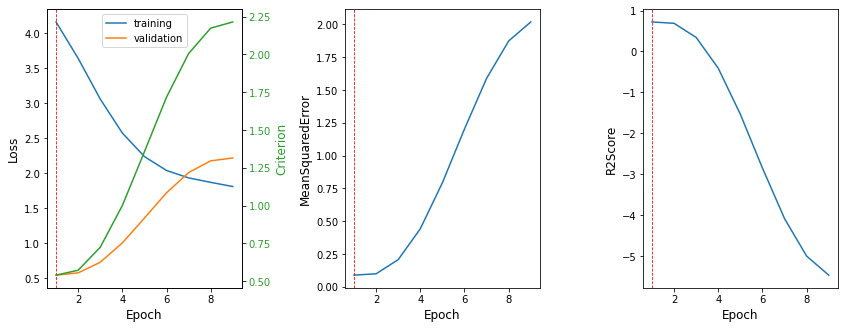

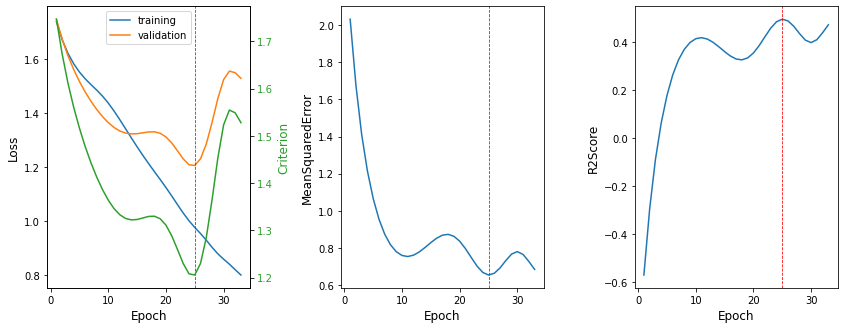

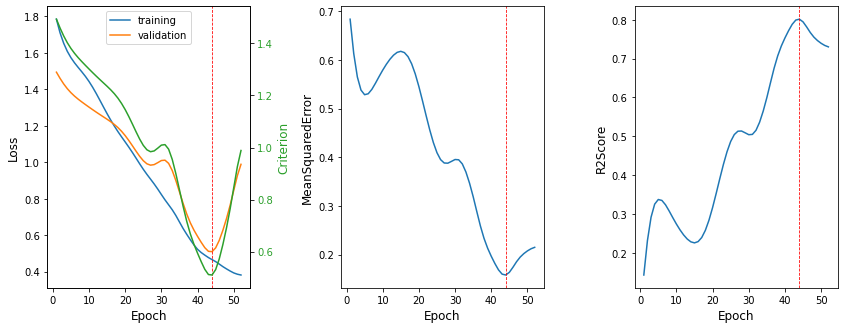

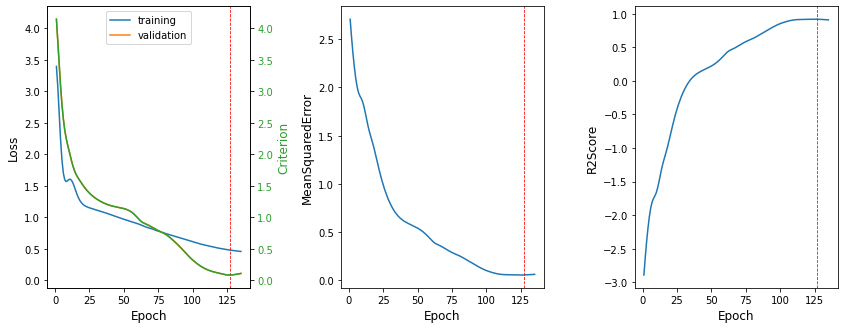

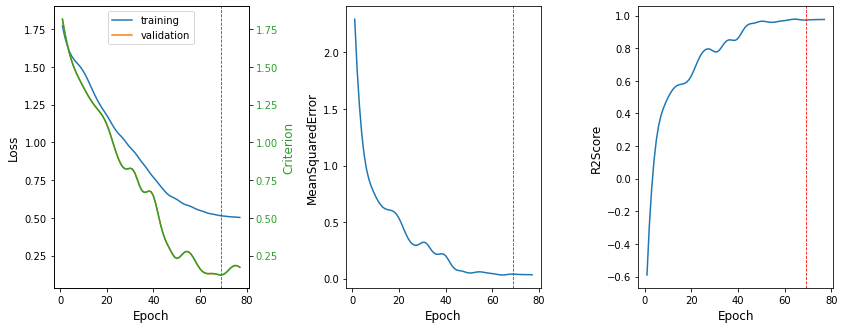

In [14]:
for i, bts in best_train_stats_dct.items():
    bts.plot(with_early_stopping_criterion=True)

In [ ]:
best_train_stats.plot(with_early_stopping_criterion=True)

In [ ]:

best_model, best_train_stats = emulator.train(
    optimizer,
    early_stopping_criterion=esc
)

In [ ]:
best_train_stats.plot(with_early_stopping_criterion=True)

In [ ]:
from GPErks.train.early_stop import PkEarlyStoppingCriterion
esc = PkEarlyStoppingCriterion(
    max_epochs, alpha=0.01, patience=8, strip_length=20
)

emulator.scaled_data.with_val = False  # let's pretend we don't have a val set

best_model, best_train_stats = emulator.train(
    optimizer,
    early_stopping_criterion=esc
)

In [ ]:
best_train_stats.plot(with_early_stopping_criterion=True)